## Import helper functions and necessary libaries 


In [1]:
import helper_functions as hf
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin    # welch F test
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings("ignore")

### Take a look at restaurant count for each location
  * DC appears to have the most number of restaurants 
  * MD appears to have the least number of restaurants 
  * All three tend to have around 2000 restaurants 

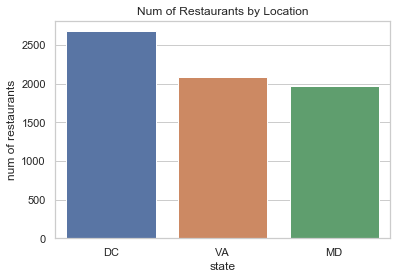

In [2]:
# import location and price df from datacleaning file
df_location_price = pd.read_pickle('data/yelp_price_location.pkl')
# obtain num_of_restaurant for each location
count_state = df_location_price.groupby('state').size(
).reset_index().rename(columns={0: 'num of restaurants'})
sns.barplot(x='state', y='num of restaurants', order=[
            'DC', 'VA', 'MD'], data=count_state)
plt.title('Num of Restaurants by Location')
plt.show()

## Split location_price dataframe into 3 groups:
  * DC, VA, MD

In [3]:
group_name = ['DC','MD','VA']
state_groups = hf.splitgroups(df_location_price, 'state', group_name)
DC = state_groups[0]
MD = state_groups[1]
VA = state_groups[2]

## Hypothesis 1:
  * restaurants tend to perform better in certain locations than others 
  * metrics:  
    * review_counts (proxy for customer traffic)
    * yelp review rating 
  * Null Hypothesis: there are no differences among the 3 locations 
  * method: one way anova 
    * check for anova assumption:  
        * Normality:  
          * Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality  
        * Homogeneity of variance  
          * Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation  
        * Independent observations (assume independent most of the time)

### Normality test 

In [4]:
# create a statistictestclass 
statisticaltests = hf.InferentialStatisticsHelperFunctions()
# check for normality 
metrics = ['review_count','rating']
statisticaltests.normality_tests(state_groups, group_name, metrics)

,DC,MD,VA
rating,not normal,not normal,not normal
review_count,not normal,not normal,not normal


### Distribution is not normal, we will use central limit theorem to produce a normal distribution by performing boostrap sampling 

In [5]:
# boostrap generate sample means from 100 samples for 100000 times (CLT)
DC_review = statisticaltests.sample_category(DC,100,100000,'review_count')
MD_review = statisticaltests.sample_category(MD,100,100000,'review_count')
VA_review = statisticaltests.sample_category(VA,100,100000,'review_count')
DC_rating = statisticaltests.sample_category(DC,100,100000,'rating')
MD_rating = statisticaltests.sample_category(MD,100,100000,'rating')
VA_rating = statisticaltests.sample_category(VA,100,100000,'rating')

### Variance equal test 

In [6]:
group_review = [DC_review, MD_review, VA_review]
# create proper table format to perform equal variance test
stacked_df_review = hf.table_transform(
    group_review, group_name, colname='review_count')
print('review_count:', statisticaltests.variance_tests(group_review))
group_rating = [DC_rating, MD_rating, VA_rating]
# create proper table format to perform equal variance test
stacked_df_rating = hf.table_transform(
    group_rating, group_name, colname='rating')
print('rating:', statisticaltests.variance_tests(group_rating))

review_count: not equal variance 
rating: not equal variance 


### Due to equal sample size, we will perform both oneway anova and welch F test to compare results 

In [7]:
# one way anova
print('review_count:', statisticaltests.one_way_anova(group_review))
print('rating:', statisticaltests.one_way_anova(group_rating))

review_count: reject Null Hypothesis
rating: reject Null Hypothesis


In [8]:
# welch F test (doesn't assume equal variance)
print('review_count:', statisticaltests.welch_f_test(
    stacked_df_review, 'review_count', 'state'))
print('rating:', statisticaltests.welch_f_test(
    stacked_df_rating, 'rating', 'state'))

review_count: reject Null Hypothesis
rating: reject Null Hypothesis


## Both reject Null Hypothesis of no difference  
 * However we don't know where the difference happens
 * it can be DC different from MD but MD and VA are the same
 * perform post ANOVA analysis to figure out the details of differences 
 * we will use tukey HSD test 

In [9]:
print('review_count:\n\n', statisticaltests.tukey_hsd(stacked_df_review,'review_count'))
print('rating:\n\n',statisticaltests.tukey_hsd(stacked_df_rating, 'rating'))

review_count:

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
    DC     MD -113.1641 0.001 -113.4855 -112.8428   True
    DC     VA  -38.9312 0.001  -39.2526  -38.6099   True
    MD     VA   74.2329 0.001   73.9115   74.5543   True
--------------------------------------------------------
rating:

 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    DC     MD  -0.2898 0.001 -0.2906 -0.2889   True
    DC     VA  -0.0615 0.001 -0.0624 -0.0607   True
    MD     VA   0.2282 0.001  0.2273  0.2291   True
---------------------------------------------------


## Results:
  * the mean diff for null hypothesis is zero 
  * the calculated 95% confidence interval is outside zero difference 
  * we will conclude as following:
    * for both rating and review counts 
      * DC has lower rating and less review counts than MD 
      * DC has lower rating and less review counts than VA
      * MD has higher rating and higher review counts than VA
    

## Based upon cuisine study, we found the following: 
  * Bars have the highest normalized review count in VA and MD 
  * Bars have the highest normalized rating in MD 
  * Ramen has the highest normalized review count and normalized rating in DC 

## After hypothesis I and II:
### We will first filter out ramen and bars and look at if there are any correlation between location and ramen vs bars 

In [10]:
# split category combo into separate rows
table = hf.split_rows(df_location_price,'Lat', 'categories', '|')
table = table.rename(columns = {'index': 'category', 0: 'Lat'})
# join table 
mergedtable = pd.merge(df_location_price,table, on = 'Lat')
# filter out only bars and ramen 
filtered_df = mergedtable[(mergedtable.category=='Bars')|(mergedtable.category =='Ramen')]
statisticaltests.chisquare_test(filtered_df, 'state','category')

'fail to reject Null Hypothesis'

### Chisquare independence test result:
  * Null Hypothesis says no correlation between category and state 
  * alternative hypthesis says there are some influence between state and category of food 
  * we fail to reject null hypothesis so we conclude no correlation between location and ramen or bars

## Hypothesis 3:
  * prices:\\$ to \\$\\$ and \\$\\$\\$ to \\$\\$\\$\\$
  * metrics:  
    * review_counts (proxy for customer traffic)
    * yelp review rating 
  * Null Hypothesis: there are no differences between \\$ to \\$\\$ and \\$\\$\\$ to \\$\\$\\$\\$
  * method: welch's T test 
    * check for welch's T test assumption:  
        * Normality

### First we will look at how price works across all locations and restaurants 
  * we replaced the null price values with 3 methods:
    * median price 
    * random value with proportions of the price distribution 
    * remove null price 
  * compare results 

In [11]:
# import location and price df for random, remove na,and median from datacleaning 
# use median to replace null price values
df_median = pd.read_pickle('data/median_price.pkl')  
# use np random to replace null price values
df_random = pd.read_pickle('data/random_price.pkl')  
# remove null price values 
df_na = pd.read_pickle('data/na_remove.pkl')

In [12]:
# generate 3 groups of DC, VA, MD for all three price df 
median_df = hf.splitgroups(df_median, 'state', group_name)
na_df = hf.splitgroups(df_na, 'state',group_name)
random_df = hf.splitgroups(df_random, 'state',group_name)

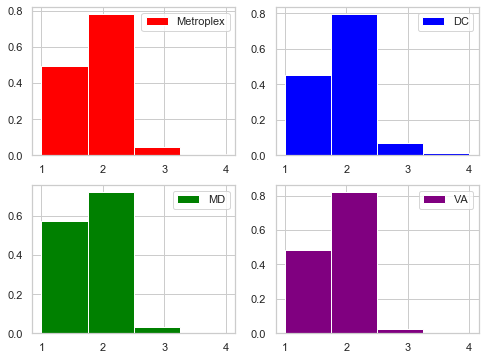

In [13]:
# check for price distribution visualization comparsion 
hf.plothist(df_median,median_df) 

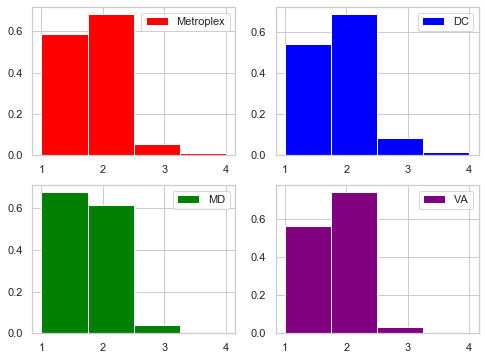

In [14]:
hf.plothist(df_na, na_df)
# similar distribution across all 

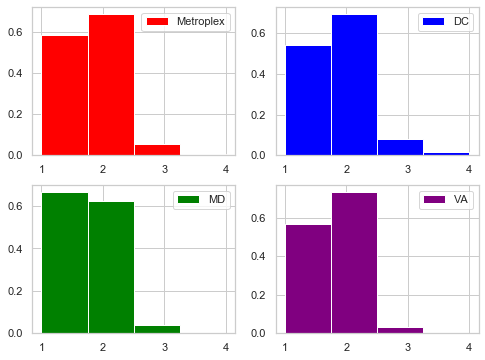

In [15]:
hf.plothist(df_random,random_df)
# distributions the same all across 

### All three NA price method seem to produce similar price range distribution 

### We will split price into 2 groups of above \\$\\$ and below \\$\\$
  * perform welch T test 
    * first check normality 

In [16]:
print('median_df:\n\n', statisticaltests.normality_tests(
    median_df, group_name, ['review_count', 'rating']))
print('na_df:\n\n', statisticaltests.normality_tests(
    na_df, group_name, ['review_count', 'rating']))
print('random_df:\n\n', statisticaltests.normality_tests(
    random_df, group_name, ['review_count', 'rating']))

median_df:

                       DC          MD          VA
rating        not normal  not normal  not normal
review_count  not normal  not normal  not normal
na_df:

                       DC          MD          VA
rating        not normal  not normal  not normal
review_count  not normal  not normal  not normal
random_df:

                       DC          MD          VA
rating        not normal  not normal  not normal
review_count  not normal  not normal  not normal


### None are normally distributed 
#### Use central limit thereom and perform bootstrap sampling 
  * first split each data into high low price range for comparison 
  * bootstrap for each group 
  * perform welch T test (assume unequal variance)

In [17]:
names = ['$$$-$$$$','$-$$']
print ('df_median review_count:')
print(statisticaltests.price_welcht(df_median,'price',2,'review_count',100,100000,names))
print ('df_na review_count:')
print(statisticaltests.price_welcht(df_na,'price',2,'review_count',100,100000,names))
print ('df_random review_count:')
print(statisticaltests.price_welcht(df_random,'price',2,'review_count',100,100000,names))

df_median review_count:
$$$-$$$$ appears to statistically perform better than $-$$
df_na review_count:
$$$-$$$$ appears to statistically perform better than $-$$
df_random review_count:
$$$-$$$$ appears to statistically perform better than $-$$


In [18]:
names = ['$$$-$$$$','$-$$']
print ('df_median rating:')
print(statisticaltests.price_welcht(df_median,'price',2,'rating',100,100000,names))
print ('df_na rating:')
print(statisticaltests.price_welcht(df_na,'price',2,'rating',100,100000,names))
print ('df_random rating:')
print(statisticaltests.price_welcht(df_random,'price',2,'rating',100,100000,names))

df_median rating:
$$$-$$$$ appears to statistically perform better than $-$$
df_na rating:
$$$-$$$$ appears to statistically perform better than $-$$
df_random rating:
$$$-$$$$ appears to statistically perform better than $-$$


### Let's focus on MD and focus on bars 

In [23]:
# look at maryland and bar only 
mask = (mergedtable.category == 'Bars') & (mergedtable.state =='MD')
MD_bars = mergedtable[mask]
# fill the value with np.random 
np.random.seed(42)
proportions = MD_bars.price.value_counts(normalize=True)
rows = []
for i, row in MD_bars[MD_bars.price.isnull()].iterrows():
    rows.append(np.random.choice(
        a=proportions.index, replace=True, p=proportions))
MD_bars.price[MD_bars.price.isnull()] = rows
MD_bars.price = MD_bars.price.astype('int')

In [27]:
np.random.seed(100)
print('review_count welch t test:')
print(statisticaltests.price_welcht(MD_bars, 'price', 2,
                                    'review_count', 50, 100000, ['$$$-$$$$', '$-$$']))
print('rating welch t test')
print(statisticaltests.price_welcht(MD_bars, 'price',
                                    2, 'rating', 50, 100000, ['$$$-$$$$', '$-$$']))

review_count welch t test:
$$$-$$$$ appears to statistically perform better than $-$$
rating welch t test
$$$-$$$$ appears to statistically perform better than $-$$


### Welch T test result for price tag:
  * all category of foods and all 3 locations:
    * all 3 price na fill value provide the same result:
      * reject Null Hypothesis 
      * higher than \\$\\$ performs better in both rating and review_count  
  * looking at MD and Bar (using np.random with proportion to fill):  
      * reject Null Hypothesis 
      * higher than \\$\\$ performs better in both rating and review_count

### Visualization of the MD_bar high low price rating and review count distribution
  * bootstrap sampling from original samples. 

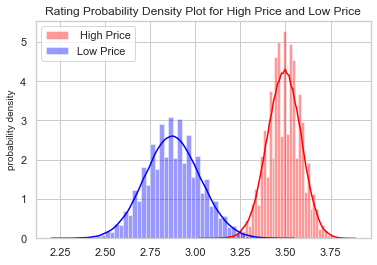

In [25]:
np.random.seed(20)
price_splits_rt = hf.samples(MD_bars, 'price', 2, 'rating')
price_high_rt = statisticaltests.sampling(price_splits_rt[0],50,100000)
price_low_rt = statisticaltests.sampling(price_splits_rt[1],50,100000)
statisticaltests.plot_distribution(price_high_rt,price_low_rt, [' High Price','Low Price'],featurename='Rating')

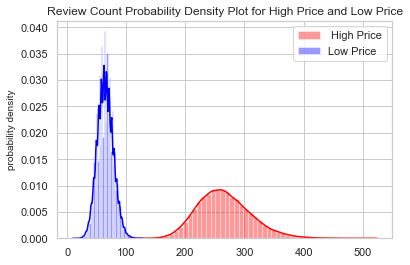

In [26]:
np.random.seed(18)
price_splits_re = hf.samples(MD_bars, 'price', 2, 'review_count')
price_high_re = statisticaltests.sampling(price_splits_re[0],50,100000)
price_low_re = statisticaltests.sampling(price_splits_re[1],50,100000)
statisticaltests.plot_distribution(price_high_re,price_low_re, [' High Price','Low Price'],'Review Count')

* Sources:  

  * https://www.yelp.com/developers/documentation/v3/business
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
  * https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
  * https://pingouin-stats.org/generated/pingouin.welch_anova.html#pingouin.welch_anova
  * https://docs.scipy.org/doc/scipy/reference/stats.html
  * https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html
